The objective of this notebook is to create a Custom Resnet structure which is able to handle all the variations of the Resnet architecture.\
The variant is choosen from the config which is passed to the model externally\
We will code things out in a modular way so that we can easily add more variants in the future\
You’ll gain insights into the core concepts of skip connections, residual blocks, and identity mappings, ultimately creating a fully functional ResNet-50 model for various computer vision tasks\
This notebook will only have the resent implementation and not the real training which will be covered in a modular way in the future notebooks

In [1]:
%autosave 300
%autoreload 2
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/insights-model-run/code/Users/soutrik.chowdhury/advanced_vision_modules_pytorch


In [3]:
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchview import draw_graph
from torch import Tensor
from typing import Type

In [5]:
def get_device():
    """Get device (if GPU is available, use GPU)"""
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


device = get_device()

#### Defining the parameters for the model which is as per the resent_version - [# of channels, # of repeatations , Times of Bottleneck layers Expansion , Bottleneck layer present or not ]

https://miro.medium.com/v2/resize:fit:828/format:webp/1*9daOqRimxMsoHPSmLD7Mrw.png

https://cdn-5f733ed3c1ac190fbc56ef88.closte.com/wp-content/uploads/2019/07/ResNet50_architecture-1.png

https://debuggercafe.com/building-resnets-from-scratch-using-pytorch/

In [6]:
model_parameters = {}
model_parameters["resnet18"] = ([64, 128, 256, 512], [2, 2, 2, 2], 1, False)
model_parameters["resnet34"] = ([64, 128, 256, 512], [3, 4, 6, 3], 1, False)
model_parameters["resnet50"] = ([64, 128, 256, 512], [3, 4, 6, 3], 4, True)
model_parameters["resnet101"] = ([64, 128, 256, 512], [3, 4, 23, 3], 4, True)
model_parameters["resnet152"] = ([64, 128, 256, 512], [3, 8, 36, 3], 4, True)

Here, model_parameters[‘resnet50’] = ([64,128,256,512],[3,4,6,3],4,True) represents the parameters for resnet-50 where

* [64,128,256,512] -> channels in each intermediate block
* [3,4,6,3] -> # repeatition for Bottlenecks in each block
* 4 -> expansion_factor. Note that 64 turns to 256, 128 to 512. All the resnet layers use the same expansion factor.
* True -> create Bottleneck layer status. True only for ResNet 50+

#### Defining the ResnetBootleneckBlock - Variations per model type in case of 18/34 only (3x3) with identity and projection mapping as per need and if resnet-50+ then we use (1x1) -> (3x3) -> (1x1) with projection mapping

In [59]:
class ResnetBasicBlock(nn.Module):
    """
    Builds the Basic Block of the ResNet model.
    For ResNet18 and ResNet34, these are stackings od 3x3=>3x3 convolutional
    layers.
    For ResNet50 and above, these are stackings of 1x1=>3x3=>1x1 (BottleNeck)
    layers.
    """

    def __init__(
        self,
        is_Bottleneck: int,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        expansion: int = 1,
        downsample: nn.Module = None,
    ) -> None:
        """
        Initializes the ResnetBasicBlock class.
        Args:
            is_Bottleneck (int): If True, uses the BottleNeck architecture.
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            stride (int): Stride for the convolutional layers.
            expansion (int): Multiplicative factor for the subsequent conv2d
                layer's output channels.
            downsample (nn.Module): Downsample the input.
        """
        super(ResnetBasicBlock, self).__init__()
        self.is_Bottleneck = is_Bottleneck
        # Multiplicative factor for the subsequent conv2d layer's output
        # channels.
        # It is 1 for ResNet18 and ResNet34, and 4 for the others.
        self.expansion = expansion
        self.downsample = downsample
        # 1x1 convolution for ResNet50 and above.
        if is_Bottleneck:
            self.conv0 = nn.Conv2d(
                in_channels, out_channels, kernel_size=1, stride=1, bias=False
            )
            self.bn0 = nn.BatchNorm2d(out_channels)
            in_channels = out_channels
        # Common 3x3 convolution for all.
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 1x1 convolution for ResNet50 and above.
        if is_Bottleneck:
            self.conv2 = nn.Conv2d(
                out_channels,
                out_channels * self.expansion,
                kernel_size=1,
                stride=1,
                bias=False,
            )
            self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        else:
            # 3x3 convolution for ResNet18 and ResNet34 and above.
            self.conv2 = nn.Conv2d(
                out_channels,
                out_channels * self.expansion,
                kernel_size=3,
                padding=1,
                bias=False,
            )
            self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        # Through 1x1 convolution if ResNet50 or above.
        if self.is_Bottleneck:
            out = self.conv0(x)
            out = self.bn0(out)
            out = self.relu(out)
        # Use the above output if ResNet50 and above.
        if self.is_Bottleneck:
            out = self.conv1(out)
        # Else use the input to the `forward` method.
        else:
            out = self.conv1(x)

        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

Create 4 Sequential blocks of multiple Bottlenecks irrespective of ResNet variant.\
Input BGR-image is passed through a 7x7 conv with stride=2 , #filters = 64 and padding=3 followed by maxpool to reduce the feature map size by half.\
Total reduction would be by 4 x times

In [60]:
class ResnetPrepBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        """
        Prepares the input for the ResNet model.
        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pooling(x)
        return x
        

In [61]:
# resnet_prep_block = ResnetPrepBlock(3, 64).to(device)
# summary(resnet_prep_block, (1, 3, 32, 32))

Next we will prepare the resnet-X block which would inculde 3-4-6-3 combinations of resnet repetations in blocks\
In the remaining architecture, only 3x3 filters are used with stride=2 in cases of reducing feature map size. Maxpool is not used.\
All the 4 blocks have feature map size reduction using stride=2 with an exception of block-1 where stride=1.\
After 4 blocks, Average Pooling is used to reduce the feature map to 1x1, followed by dropout and 1 Fully Connected Layer joining the flattened feature map with the output classes 

In [62]:
class ResNetX(nn.Module):
    def __init__(
        self,
        resnet_variant,
        img_channels: int,
        num_classes: int = 1000,
    ) -> None:
        """
        Initializes the ResNet model.
        Args:
            resnet_variant (str): Variant of ResNet model.
            img_channels (int): Number of input channels.
            num_classes (int): Number of output classes.
        """
        super(ResNetX, self).__init__()
        self.channels_list = resnet_variant[0]
        self.repeatition_list = resnet_variant[1]
        self.expansion = resnet_variant[2]
        self.is_Bottleneck = resnet_variant[3]

        self.in_channels = 64
        # prep layer
        self.conv1 = nn.Conv2d(
            in_channels=img_channels,
            out_channels=self.in_channels,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # layer 1
        self.layer1 = self._make_layer(64, self.repeatition_list[0], stride=1)
        # layer 2
        self.layer2 = self._make_layer(
            128,
            self.repeatition_list[1],
            stride=2,
        )
        # layer 3
        self.layer3 = self._make_layer(
            256,
            self.repeatition_list[2],
            stride=2,
        )
        # layer 4
        self.layer4 = self._make_layer(
            512,
            self.repeatition_list[3],
            stride=2,
        )

        # classification layer
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512 * self.expansion, num_classes),
        )
    def _make_layer(
        self,
        out_channels: int,
        num_blocks: int,
        stride: int = 1,
    ) -> nn.Sequential:
        """
        Creates a layer of the ResNet model.
        Args:
            out_channels (int): Number of output channels.
            num_blocks (int): Number of blocks in the layer.
            stride (int): Stride for the convolutional layers.
        Returns:
            nn.Sequential: A layer of the ResNet model.
        """
        downsample = None
        if stride != 1 or self.in_channels != out_channels * self.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels * self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            ResnetBasicBlock(
                self.is_Bottleneck,
                self.in_channels,
                out_channels,
                stride,
                self.expansion,
                downsample,
            )
        )
        self.in_channels = out_channels * self.expansion

        for i in range(1, num_blocks):
            layers.append(
                ResnetBasicBlock(
                    self.is_Bottleneck,
                    self.in_channels,
                    out_channels,
                )
            )
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        print("Attempting first resnet")
        x = self.layer1(x)
        print("Attempting second resnet")
        x = self.layer2(x)
        print("Attempting third resnet")
        x = self.layer3(x)
        print("Attempting fourth resnet")
        x = self.layer4(x)
        x = self.classifier(x)
        return x

In [63]:
model_nw = ResNetX(
    resnet_variant=model_parameters["resnet34"], img_channels=3, num_classes=10
).to(device)
print(model_nw)

ResNetX(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): ResnetBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(

In [64]:
summary(model_nw, (1,3, 32,32))

Attempting first resnet
Attempting second resnet
Attempting third resnet
Attempting fourth resnet


Layer (type:depth-idx)                   Output Shape              Param #
ResNetX                                  [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 16, 16]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 16, 16]           128
├─ReLU: 1-3                              [1, 64, 16, 16]           --
├─MaxPool2d: 1-4                         [1, 64, 8, 8]             --
├─Sequential: 1-5                        [1, 64, 8, 8]             --
│    └─ResnetBasicBlock: 2-1             [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-1                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-3                    [1, 64, 8, 8]             --
│    │    └─Conv2d: 3-4                  [1, 64, 8, 8]             36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 8, 8]             128
│    │    └─ReLU: 3-6                    [1, 64, 8, 8]             --
│

In [65]:
x = torch.randn(3, 3, 32, 32).to(device)
output = model_nw(x)
print(output.shape)

Attempting first resnet
Attempting second resnet
Attempting third resnet
Attempting fourth resnet
torch.Size([3, 10])


Attempting first resnet
Attempting second resnet
Attempting third resnet
Attempting fourth resnet


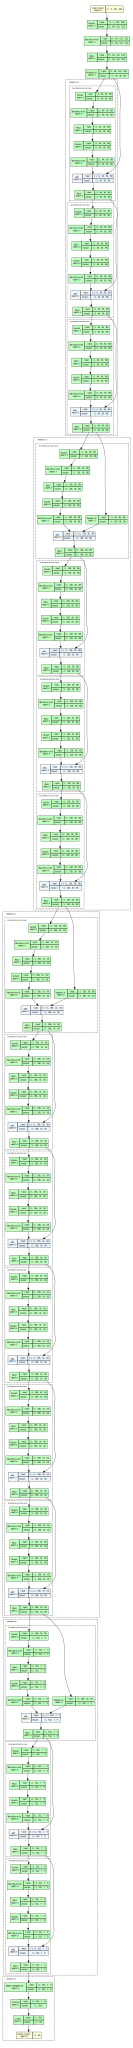

In [66]:
model_graph = draw_graph(
    model_nw, input_size=(1, 3, 224, 224), expand_nested=True, roll=True
)
model_graph.resize_graph(scale=10)
model_graph.visual_graph